In [ ]:
import numpy as np 
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow as show
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.layers
from tensorflow.keras.layers import BatchNormalization,Conv2D,Conv1D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU,Activation,Flatten,Dense,Reshape,Input,Dropout,InputLayer
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
import os
import glob
import tensorflow as tf
from google.colab.patches import cv2_imshow as show
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Thu Sep 23 04:40:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


using keras

In [ ]:
resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=(288,288,3), pooling=None )

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 288, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 294, 294, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 144, 144, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 146, 146, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
for layer in resnet.layers[:-75]:
  layer.trainable = False
for layer in resnet.layers[-75:]:
  layer.trainable = True

In [ ]:
tf.keras.backend.clear_session()

# Transfer learning , using ResNet pre-trained model with ImageNet weights
# don't include the top layres (dense layers) because it used for classify 6000 class on imagenet data set
# input will take 256x256 RGB images (3 channels)

model = Sequential([
resnet,
layers.GlobalAveragePooling2D(),
layers.Dense(512, activation='relu'),
layers.Dropout(0.3),
layers.Dense(256, activation='relu'),
layers.Dropout(0.3),
layers.Dense  (17, activation='softmax')])


# RMSprop oprimizer will dapt the learning rate also
# binary_crossentropy loss function 


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 9, 9, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 17)                4

In [ ]:
from tensorflow.keras.optimizers import Adam,RMSprop

from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10) # change 2

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
# Flow training images in batches of 64 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/fishcare/train/',  # This is the source directory for training images
        target_size=(288, 288),  
        batch_size=64,
        class_mode='categorical')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/fishcare/validation',  # This is the source directory for training images
        target_size=(288, 288), 
        batch_size=32,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/fishcare/test/',  # This is the source directory for training images
        target_size=(288, 288),  
        batch_size=16,
        shuffle = False,
        class_mode='categorical')

Found 2603 images belonging to 17 classes.
Found 705 images belonging to 17 classes.
Found 134 images belonging to 17 classes.


In [ ]:
train_generator.class_indices

{'Angelfish': 0,
 'Arowana': 1,
 'Barb': 2,
 'Bettafish': 3,
 'Carp_and_Koi': 4,
 'Catfish': 5,
 'Cichlid': 6,
 'Discus': 7,
 'Goldfish': 8,
 'Gourami': 9,
 'Guppies': 10,
 'Neon_Tetra': 11,
 'Oscar': 12,
 'Platy_and_Molly': 13,
 'Swordtail': 14,
 'Tetra': 15,
 'Zebra_Danios': 16}

In [ ]:
train_generator.classes

array([ 0,  0,  0, ..., 16, 16, 16], dtype=int32)

In [ ]:
model.fit(X_train, Y_train, batch_size=64, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test), callbacks=[LearningRateScheduler(scheduler, verbose=1)])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=40,  
      epochs=50,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=20)

Epoch 1/50
40/40 [==============================] - 804s 19s/step - loss: 2.0617 - accuracy: 0.3726 - val_loss: 18.3916 - val_accuracy: 0.2031
Epoch 2/50
40/40 [==============================] - 87s 2s/step - loss: 1.4024 - accuracy: 0.5900 - val_loss: 6.7874 - val_accuracy: 0.2297
Epoch 3/50
40/40 [==============================] - 79s 2s/step - loss: 1.1797 - accuracy: 0.6534 - val_loss: 3.2419 - val_accuracy: 0.3984
Epoch 4/50
40/40 [==============================] - 79s 2s/step - loss: 0.9360 - accuracy: 0.7129 - val_loss: 2.0786 - val_accuracy: 0.5688
Epoch 5/50
40/40 [==============================] - 79s 2s/step - loss: 0.7244 - accuracy: 0.7842 - val_loss: 1.7040 - val_accuracy: 0.6812
Epoch 6/50
40/40 [==============================] - 79s 2s/step - loss: 0.7047 - accuracy: 0.7924 - val_loss: 1.3535 - val_accuracy: 0.7031
Epoch 7/50
40/40 [==============================] - 78s 2s/step - loss: 0.6448 - accuracy: 0.8113 - val_loss: 1.4677 - val_accuracy: 0.7078
Epoch 8/50
40/40 

In [ ]:
model.save("fish_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
!cp fish_model.h5 gdrive/MyDrive/fishcare/new_model.h5

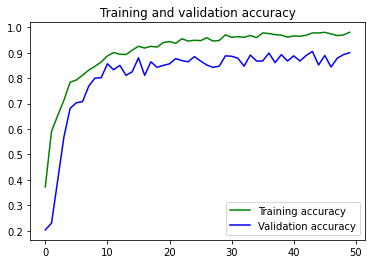

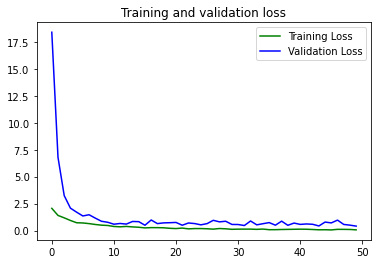

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
train_generator.class_indices

{'Angelfish': 0,
 'Arowana': 1,
 'Barb': 2,
 'Bettafish': 3,
 'Carp_and_Koi': 4,
 'Catfish': 5,
 'Cichlid': 6,
 'Discus': 7,
 'Goldfish': 8,
 'Gourami': 9,
 'Guppies': 10,
 'Neon_Tetra': 11,
 'Oscar': 12,
 'Platy_and_Molly': 13,
 'Swordtail': 14,
 'Tetra': 15,
 'Zebra_Danios': 16}

In [ ]:
model = keras.models.load_model('gdrive/MyDrive/fishcare/fish_model.h5')

In [ ]:
classes = np.array(['Angelfish', 'Arowana', 'Barb', 'Bettafish', 'Carp_and_Koi', 'Catfish', 'Cichlid', 'Discus', 'Goldfish',
 'Gourami', 'Guppies', 'Neon_Tetra', 'Oscar', 'Platy_and_Molly', 'Swordtail', 'Tetra', 'Zebra_Danios'])

In [ ]:
#testing
test_score = model.evaluate_generator(test_generator, 16)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 94.03%
[INFO] Loss:  0.43495482206344604


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
Normalized confusion matrix
Classification Report
                 precision    recall  f1-score   support

      Angelfish       1.00      0.88      0.93         8
        Arowana       1.00      1.00      1.00         5
           Barb       0.80      1.00      0.89         8
      Bettafish       1.00      1.00      1.00         8
   Carp_and_Koi       1.00      1.00      1.00        10
        Catfish       1.00      1.00      1.00         5
        Cichlid       1.00      0.60      0.75         5
         Discus       1.00      1.00      1.00        10
       Goldfish       1.00      0.88      0.93         8
        Gourami       0.75      1.00      0.86         6
        Guppies       1.00      0.88      0.93         8
     Neon_Tetra       1.00      1.00      1.00         8
          Oscar       1.00      1.00      1.00         5
Platy_and_Molly       0.80      1.00      0.89        12
      Swordtail       1.00      1.00      1.00         8
          Tetra     

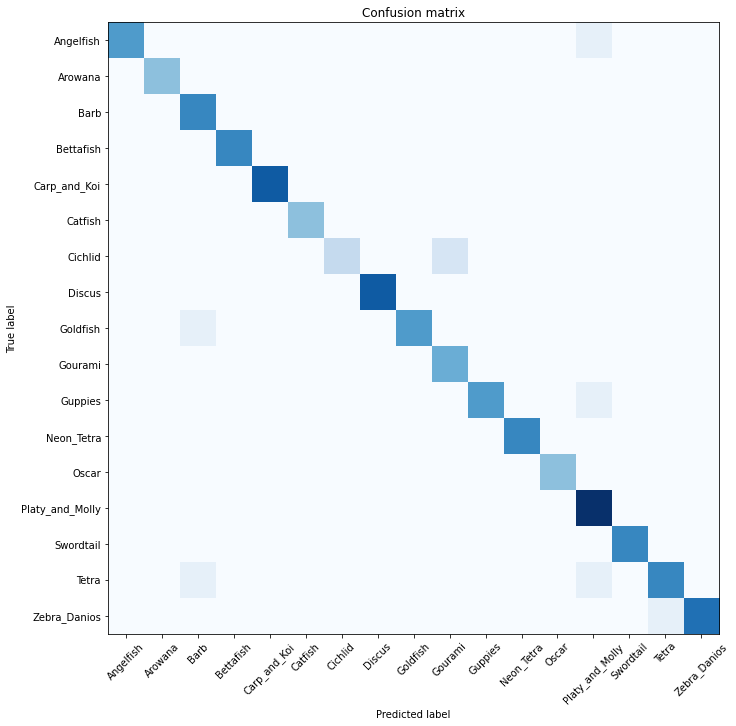

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

normalize = True

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
#plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
if normalize:
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cm = np.around(cm, decimals=2)
  cm[np.isnan(cm)] = 0.0
  print("Normalized confusion matrix")
else:
  print('Confusion matrix, without normalization')
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#Print the Target names
 
#shuffle=False
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

['Gourami', 'Cichlid', 'Discus', 'Bettafish']


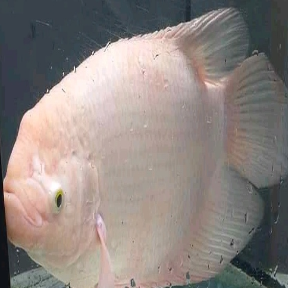

['Angelfish', 'Carp_and_Koi', 'Catfish', 'Bettafish']


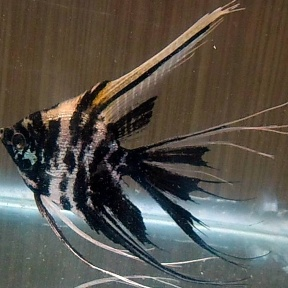

['Catfish', 'Tetra', 'Angelfish', 'Cichlid']


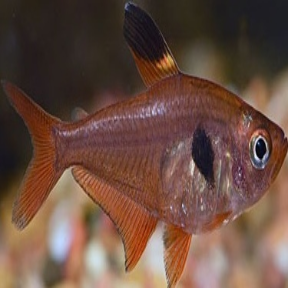

['Zebra_Danios', 'Platy_and_Molly', 'Swordtail', 'Cichlid']


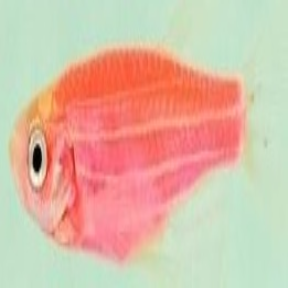

['Discus', 'Oscar', 'Gourami', 'Cichlid']


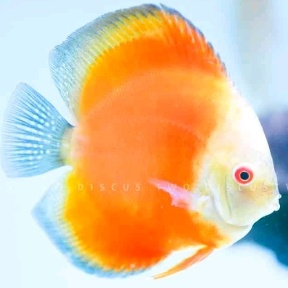

['Goldfish', 'Cichlid', 'Catfish', 'Swordtail']


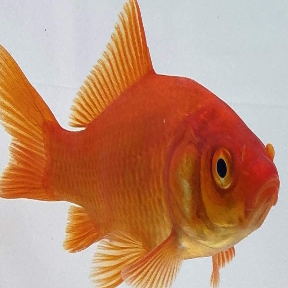

['Platy_and_Molly', 'Bettafish', 'Guppies', 'Swordtail']


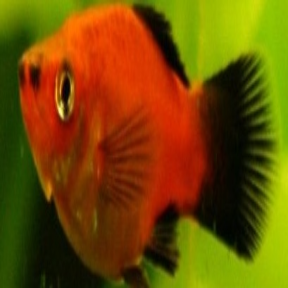

['Oscar', 'Angelfish', 'Carp_and_Koi', 'Cichlid']


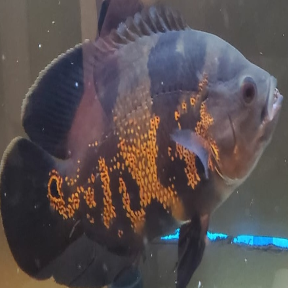

['Carp_and_Koi', 'Arowana', 'Swordtail', 'Platy_and_Molly']


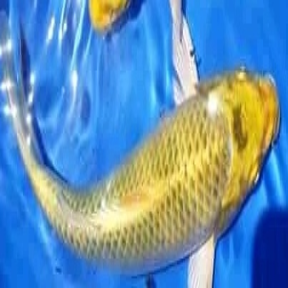

['Platy_and_Molly', 'Swordtail', 'Gourami', 'Cichlid']


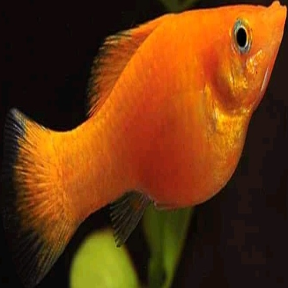

['Neon_Tetra', 'Swordtail', 'Barb', 'Tetra']


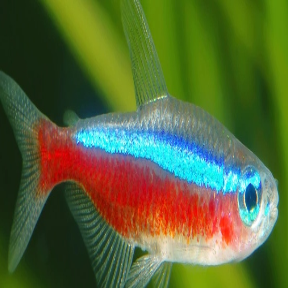

In [ ]:
#manual testing
images = [] 
image_list = glob.glob("*.jpg")
for image_name in image_list:
  img = cv2.imread(image_name)     
  img = cv2.resize(img,(288,288))    
  scores = np.argsort(model.predict(np.reshape(img/255,[1,288,288,3]))).flatten()
  predicted = [classes[i] for i in scores[-1:-5:-1]]
  print(predicted)
  show(img)  


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 286, 286, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 143, 143, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 141, 141, 32)      4640      
_________________________________________________________________
dropout_3 (Dropout)          (None, 141, 141, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 70, 70, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 68, 68, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 68, 68, 64)       

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in resnet.layers])

In [ ]:
for layer in resnet.layers:
    print(layer.name,layer)

input_1 <keras.engine.input_layer.InputLayer object at 0x7f9f1989a810>
conv1_pad <keras.layers.convolutional.ZeroPadding2D object at 0x7f9f1983ee10>
conv1_conv <keras.layers.convolutional.Conv2D object at 0x7f9f197fd290>
pool1_pad <keras.layers.convolutional.ZeroPadding2D object at 0x7f9f197ce790>
pool1_pool <keras.layers.pooling.MaxPooling2D object at 0x7f9f197fdad0>
conv2_block1_preact_bn <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9f10709590>
conv2_block1_preact_relu <keras.layers.core.Activation object at 0x7f9f197fde10>
conv2_block1_1_conv <keras.layers.convolutional.Conv2D object at 0x7f9f106b5750>
conv2_block1_1_bn <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9f106be3d0>
conv2_block1_1_relu <keras.layers.core.Activation object at 0x7f9f106c12d0>
conv2_block1_2_pad <keras.layers.convolutional.ZeroPadding2D object at 0x7f9f10709f90>
conv2_block1_2_conv <keras.layers.convolutional.Conv2D object at 0x7f9f106cb2

In [ ]:
layer_dict

{'dense': <keras.layers.core.Dense at 0x7f9f1015a210>,
 'dense_1': <keras.layers.core.Dense at 0x7f9f1015aad0>,
 'dense_2': <keras.layers.core.Dense at 0x7f9f10161090>,
 'dropout': <keras.layers.core.Dropout at 0x7f9f1015a510>,
 'dropout_1': <keras.layers.core.Dropout at 0x7f9f1015ae50>,
 'global_average_pooling2d': <keras.layers.pooling.GlobalAveragePooling2D at 0x7f9f103d76d0>,
 'resnet50v2': <keras.engine.functional.Functional at 0x7f9f103ea9d0>}

In [ ]:
img = train_generator.next()

(64, 288, 288, 3)


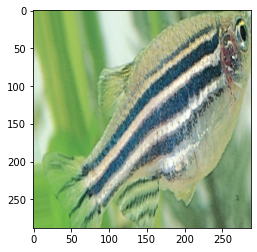

In [ ]:
for _ in range(1):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [ ]:
test =img[0].reshape(1,288,288,3)

In [ ]:
first_layer_activation.shape

(256,)

(9, 9, 2048)


TypeError: ignored

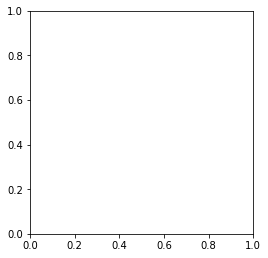

In [ ]:
from keras import models
layer_outputs = resnet.layers[-4].output
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=resnet.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(test) 

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation, cmap='viridis')

In [ ]:
model = tf.keras.models.load_model('gdrive/MyDrive/fishcare/new_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("fish_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwi_y5d1r/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


98841880

In [ ]:
!cp /content/fish_model.tflite /content/gdrive/MyDrive/fishcare/new_fish_model.tflite

In [ ]:
import pandas as pd
from datetime import datetime,timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.style.use("seaborn")

data = pd.read_json("db.json")['array']

dates = []
temps = []
for i in data:
    dates.append(i[1])
    temps.append(i[0])
dates = pd.DataFrame(dates,columns=['ds'])
temps = pd.DataFrame(temps,columns=['y'])
dataset = pd.concat([temps,dates],axis=1)
dataset = dataset[dataset['y']!=-127]
#print(dataset)

#plt.figure(figsize=(15,5))
#plt.plot(dataset['ds'],dataset['y'],linestyle="solid")

#plt.gcf().autofmt_xdate()
#plt.show()


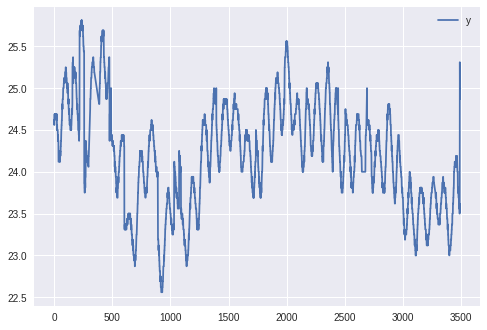

In [ ]:
dataset.plot()

In [ ]:
dataset['ds'].min

<bound method Series.min of 0       Thursday, September 16 2021 18:45:53
1       Thursday, September 16 2021 19:00:48
2       Thursday, September 16 2021 19:15:43
3       Thursday, September 16 2021 19:30:39
4       Thursday, September 16 2021 19:45:34
                        ...                 
3485       Monday, November 01 2021 08:33:28
3486       Monday, November 01 2021 08:48:23
3487       Monday, November 01 2021 09:03:18
3488    Saturday, September 18 2021 18:44:59
3489    Saturday, September 25 2021 18:00:45
Name: ds, Length: 3374, dtype: object>

In [ ]:
!pip install prophet

     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641280 sha256=9284ac595219ae33fe7d355ce5fcb6946d8310ce4d8cbbc72c5a797c3586dd3c
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
from prophet import Prophet
m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True,changepoint_prior_scale=0.01)
m.fit(dataset)




In [ ]:
future = m.make_future_dataframe(periods=4*48,freq='H',include_history=False)
times = []
for i in future['ds']:
    for j in range(4):
        times.append(i- pd.Timedelta(minutes=15*(3-j)))
future = pd.DataFrame(times,columns=['ds'])

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2021-12-27 20:44:05,24.053417,23.172870,24.933664
1,2021-12-27 20:59:05,24.059160,23.220255,24.945908
2,2021-12-27 21:14:05,24.063502,23.166545,24.929079
3,2021-12-27 21:29:05,24.066251,23.178421,24.896883
4,2021-12-27 21:44:05,24.067248,23.239423,24.917699
...,...,...,...,...
763,2022-01-04 19:29:05,24.011243,23.176090,24.906864
764,2022-01-04 19:44:05,24.020856,23.170624,24.905657
765,2022-01-04 19:59:05,24.030072,23.144769,24.901755
766,2022-01-04 20:14:05,24.038727,23.191070,24.921732


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][20:30]

,ds,yhat,yhat_lower,yhat_upper
20,2021-11-01 06:29:37,23.048053,22.714010,23.368352
21,2021-11-01 06:44:37,23.026901,22.711161,23.366531
22,2021-11-01 06:59:37,23.006967,22.660705,23.319087
23,2021-11-01 07:14:37,22.988441,22.653168,23.326736
24,2021-11-01 07:29:37,22.971498,22.654613,23.312131
25,2021-11-01 07:44:37,22.956293,22.614235,23.284033
26,2021-11-01 07:59:37,22.942957,22.610992,23.273081
27,2021-11-01 08:14:37,22.931596,22.603456,23.251225
28,2021-11-01 08:29:37,22.922289,22.570623,23.249616
29,2021-11-01 08:44:37,22.915087,22.595161,23.222636


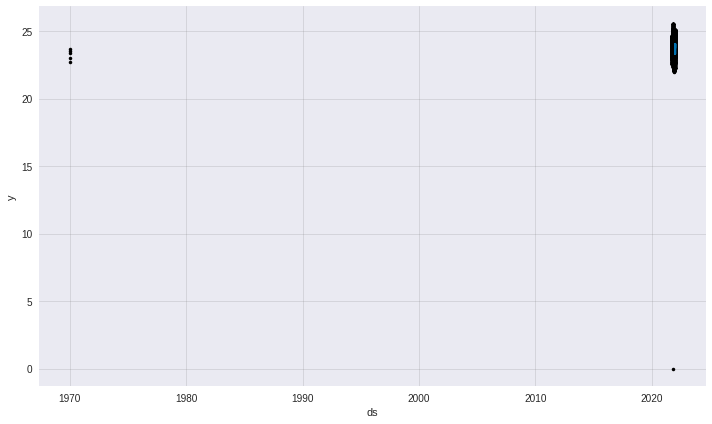

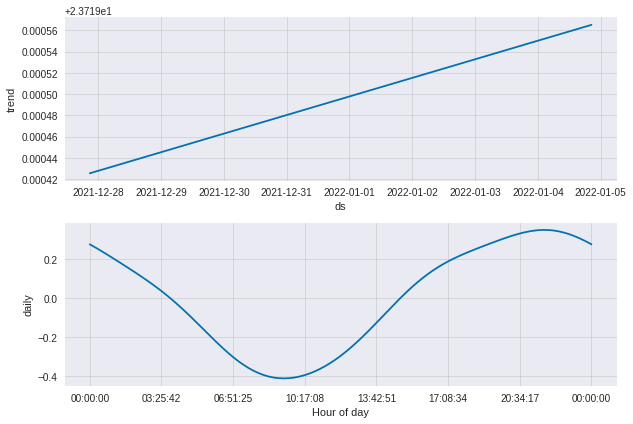

In [ ]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)
plot_components_plotly(m, forecast)

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
data = pd.read_json("db.json")['array']

dates = []
temps = []
for i in data:
    dates.append(i[1])
    temps.append(i[0])
dates = pd.DataFrame(dates,columns=['ds'])
temps = pd.DataFrame(temps,columns=['y'])
dataset = pd.concat([temps,dates],axis=1)
dataset = dataset[dataset['y']!=-127]

In [ ]:
dataset.head()

,y,ds
0,23.75,11:31
1,23.81,11:46
2,23.87,12:01
3,23.94,12:16
4,23.94,12:31


In [ ]:
new = []

In [ ]:
for i in range(dataset.shape[0]):
  new.append(dataset['ds'].iloc[i][-8:-3])

In [ ]:
dataset['ds'] = new

In [ ]:
X = dataset

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

AttributeError: ignored

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [ ]:

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence.iloc[i:end_ix], sequence.iloc[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = dataset['y']
# choose a number of time steps
n_steps = 30
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(30, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=10, verbose=0)
# demonstrate prediction


In [ ]:
x_input = array([24.87, 24.81, 24.87, 24.81, 24.81, 24.81, 24.81, 24.87, 24.87, 24.81, 24.81, 24.81, 24.81, 24.75, 24.81, 24.81, 24.75, 24.75, 24.75, 24.69, 24.69, 24.62, 24.62, 24.62, 24.56, 24.56, 24.56, 24.5, 24.44, 24.44])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[24.575577]]


In [ ]:
print(dataset['y'].iloc[1375:1406].tolist())

[24.87, 24.81, 24.87, 24.81, 24.81, 24.81, 24.81, 24.87, 24.87, 24.81, 24.81, 24.81, 24.81, 24.75, 24.81, 24.81, 24.75, 24.75, 24.75, 24.69, 24.69, 24.62, 24.62, 24.62, 24.56, 24.56, 24.56, 24.5, 24.44, 24.44, 24.37]


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()
open("temp.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmprmmiecqh/assets


INFO:tensorflow:Assets written to: /tmp/tmprmmiecqh/assets


52684

In [ ]:
from sklite import LazyExport
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np

df = pd.read_csv('data/symptoms_disease.csv')

symptoms = df.columns
symptoms = symptoms[1:]
x = df[symptoms]
y = df['Disease']
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(x,y)
lazy = LazyExport(clf)
lazy.save('svc_diseases.json')

In [ ]:
pred = np.zeros(30)
predictions =[]

In [ ]:
rms = 0
for i in range(0,6946):
  x = array(dataset['y'].iloc[i:i+31].tolist())
  y = x[-1]
  x = x[0:-1].reshape((1, n_steps, n_features))
  yhat = model.predict(x, verbose=0).reshape(1)
  predictions.append(yhat)
  np.append(pred,yhat)  



In [ ]:
(rms*rms)**0.25

28.505425931713972

In [ ]:
dataset.shape

(6977, 2)

In [ ]:
predictions = np.array(predictions)

In [ ]:
pred = np.zeros((31,1))

In [ ]:
temp.shape

(6977, 1)

In [ ]:
temp = np.concatenate((pred,predictions),axis=0)

In [ ]:
dataset['err'] = dataset['y']-dataset['pred']

In [ ]:
dataset.tail()

,y,ds,pred,err
7541,23.62,"Monday, December 27 2021 19:29:26",23.550980,0.069020
7542,23.62,"Monday, December 27 2021 19:44:19",23.579964,0.040036
7543,23.62,"Monday, December 27 2021 19:59:14",23.609850,0.010150
7544,23.69,"Monday, December 27 2021 20:14:10",23.635269,0.054731
7545,23.69,"Monday, December 27 2021 20:29:05",23.658726,0.031274


In [ ]:
sum(dataset['err'].tolist())/dataset.shape[0]

0.017418559597781692

In [ ]:
dataset.shape

(6977, 4)